# **This file is to run code to produce plots for the Summer 2025 SULI appointment**
#### *Coded by Brandon Swanson<br>Mentored by Bhupendra Raut*

                         pm2.5      pm1.0     pm10.0        co        no  \
time                                                                       
2023-05-20 00:00:00  28.350000  24.050000  35.450000  0.218233  0.012033   
2023-05-20 00:30:00  22.733333  19.316667  28.150000  0.179633  0.012567   
2023-05-20 01:00:00  23.266667  19.966667  28.416667  0.173333  0.013800   
2023-05-20 01:30:00  20.916667  17.783333  25.566667  0.179433  0.016300   
2023-05-20 02:00:00  19.633333  16.633333  23.583333  0.185333  0.017000   
2023-05-20 02:30:00  19.766667  17.050000  24.183333  0.183633  0.017033   
2023-05-20 03:00:00  12.483333  10.800000  15.716667  0.151800  0.016567   
2023-05-20 03:30:00   6.500000   5.566667  10.016667  0.114400  0.016900   
2023-05-20 04:00:00   5.966667   5.150000   9.050000  0.095667  0.017167   
2023-05-20 04:30:00   5.800000   5.033333   8.483333  0.083400  0.017167   

                           o3       no2  temperature  dewpoint    u_wind  \
time       

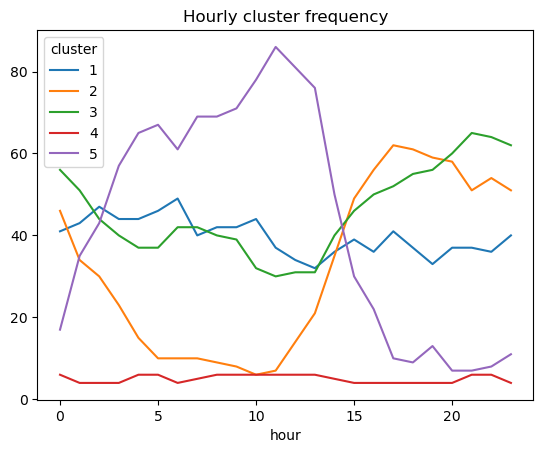

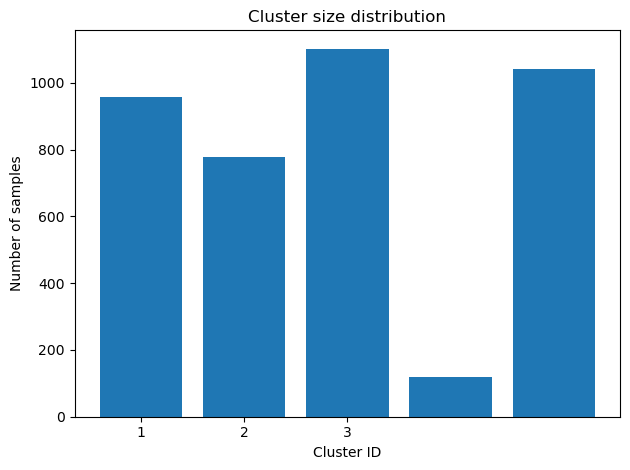

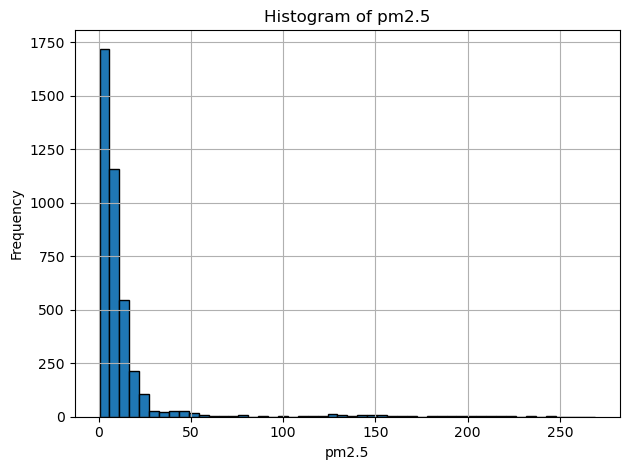

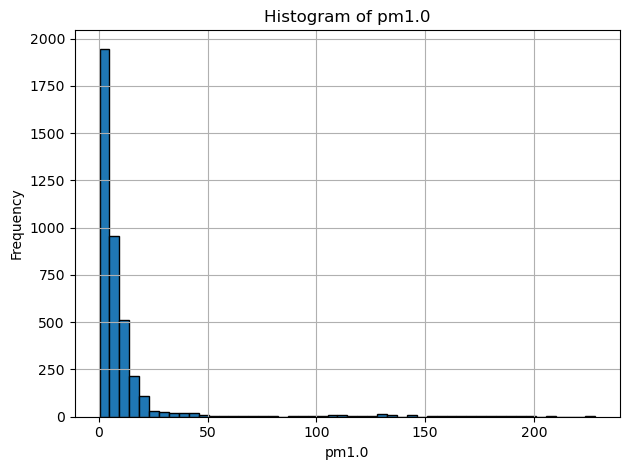

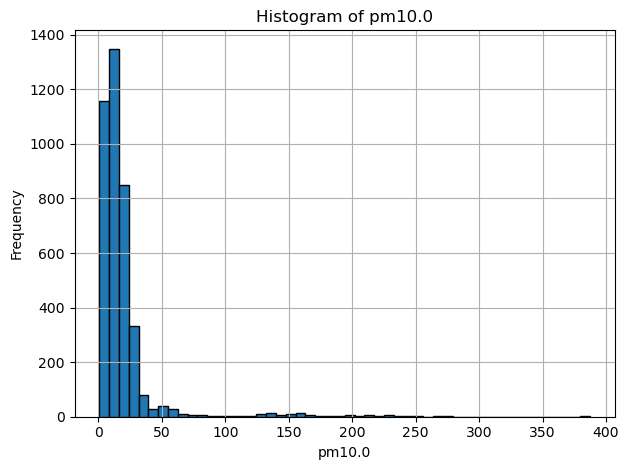

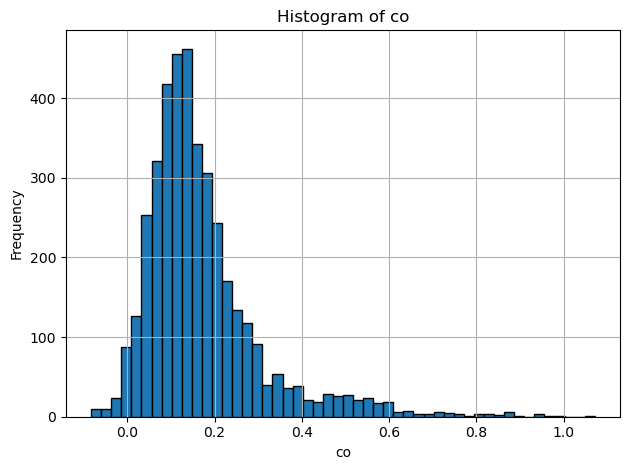

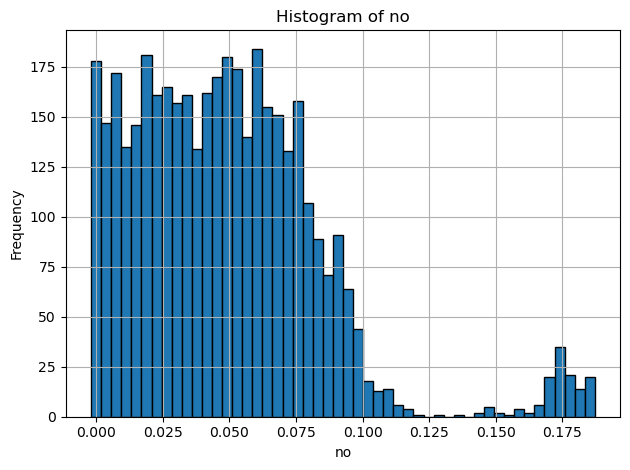

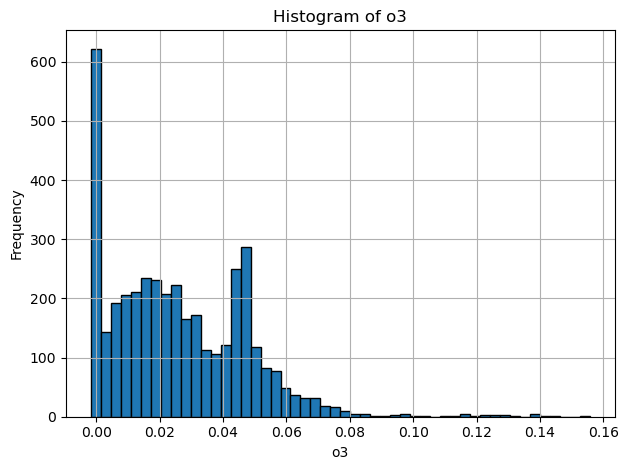

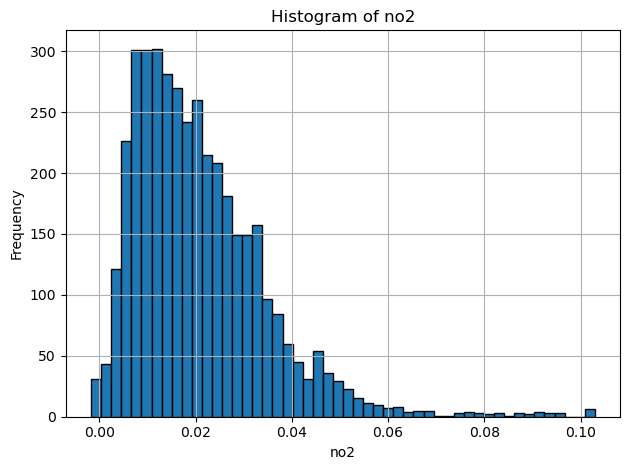

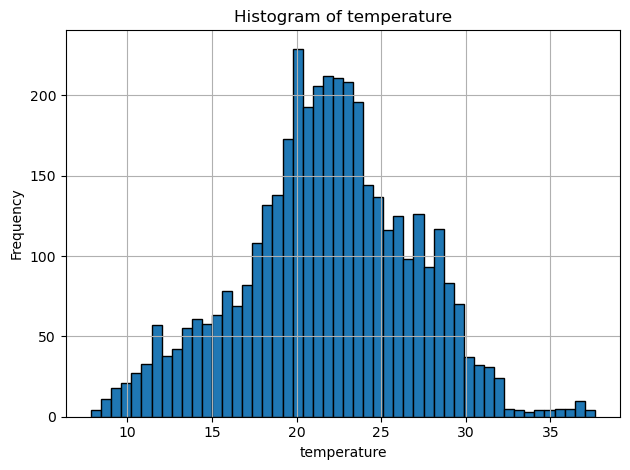

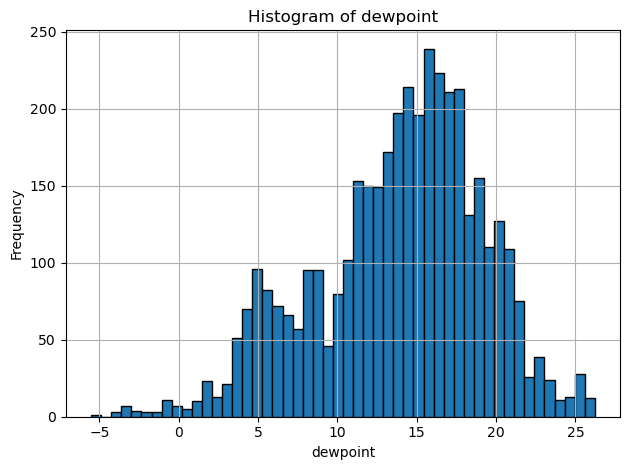

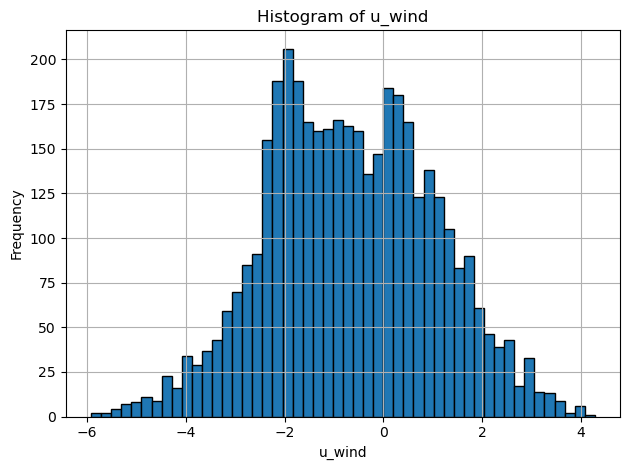

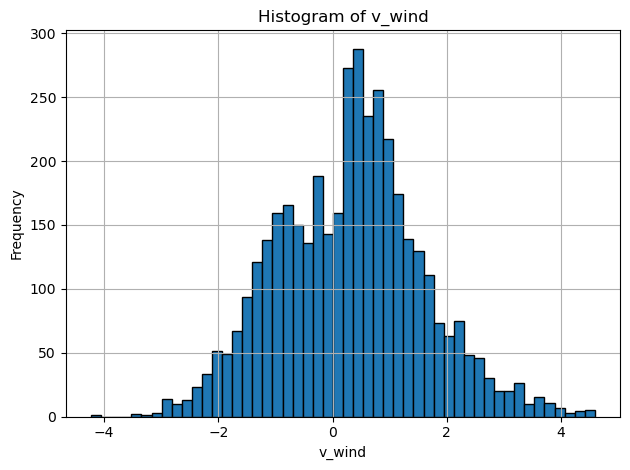

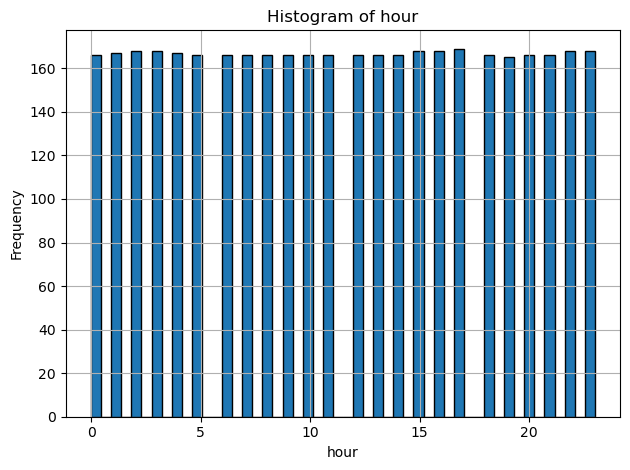

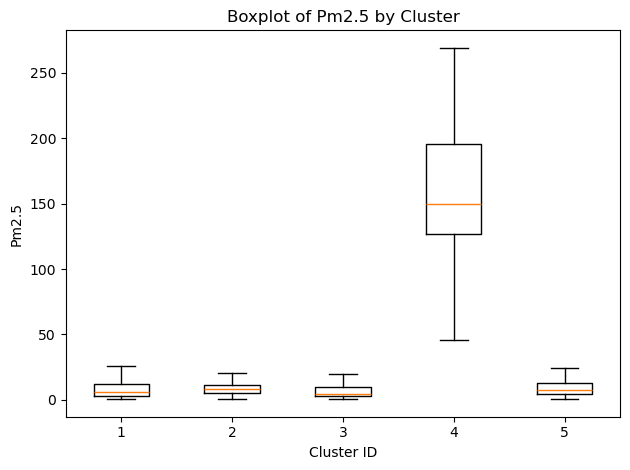

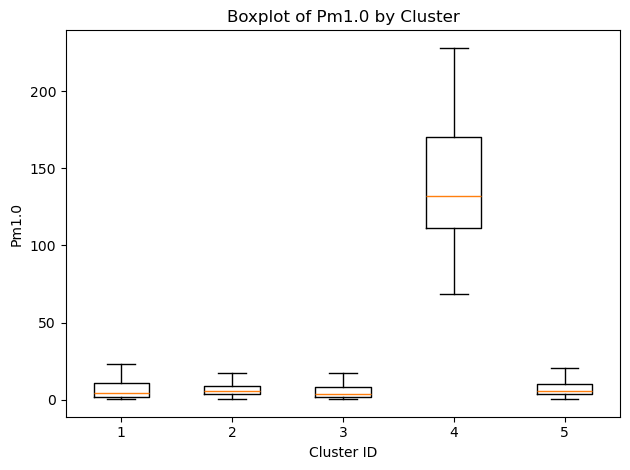

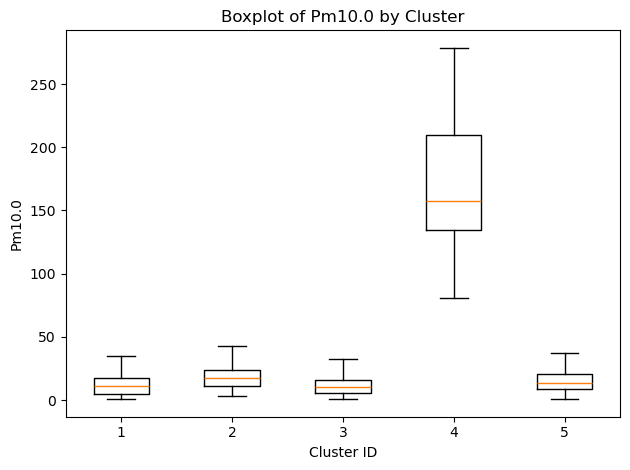

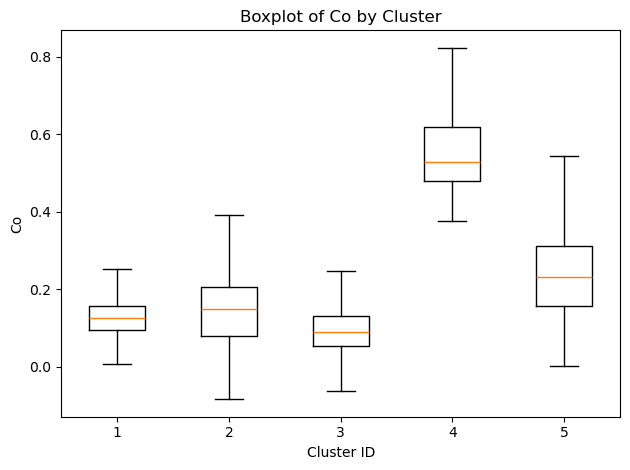

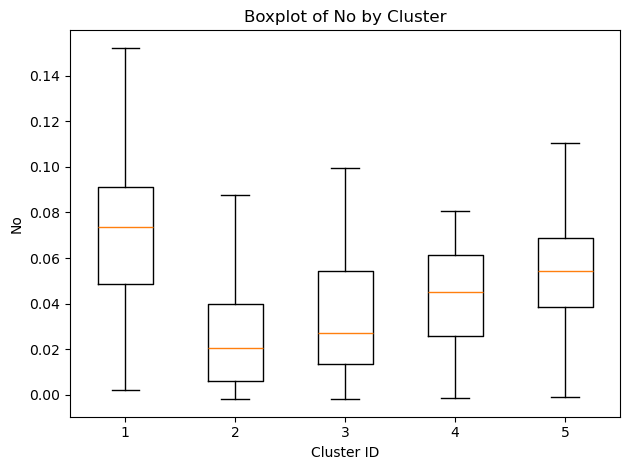

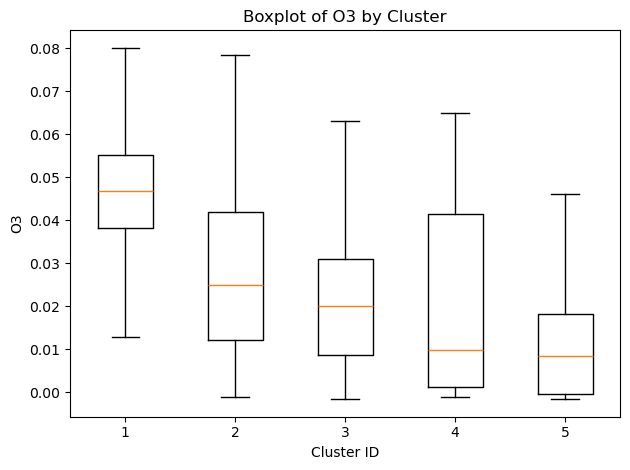

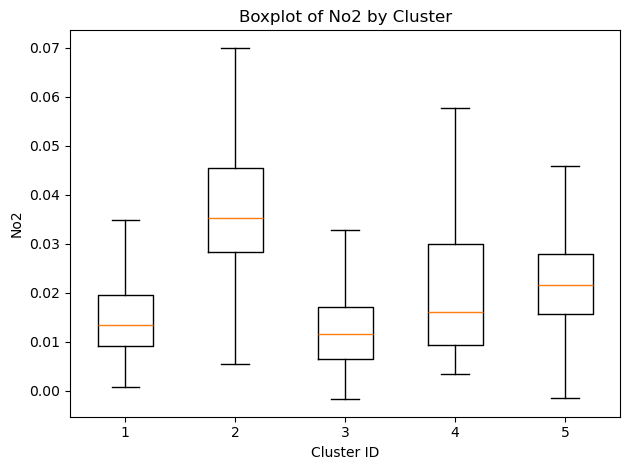

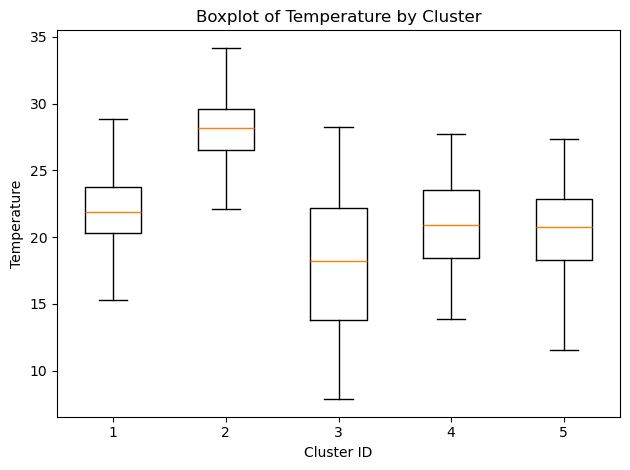

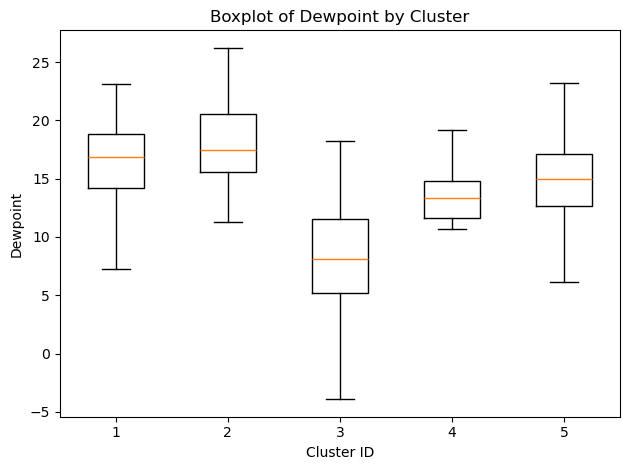

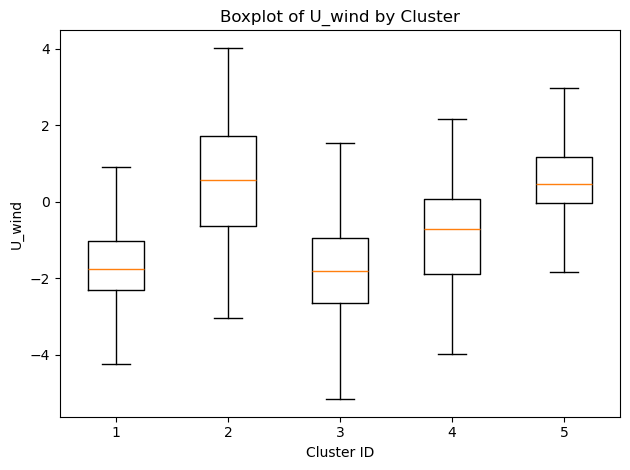

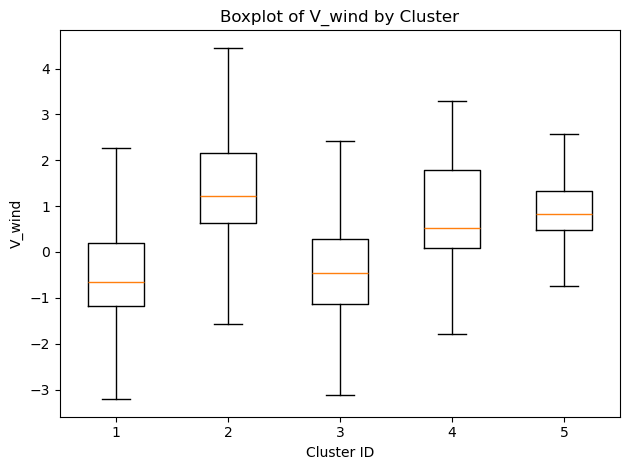

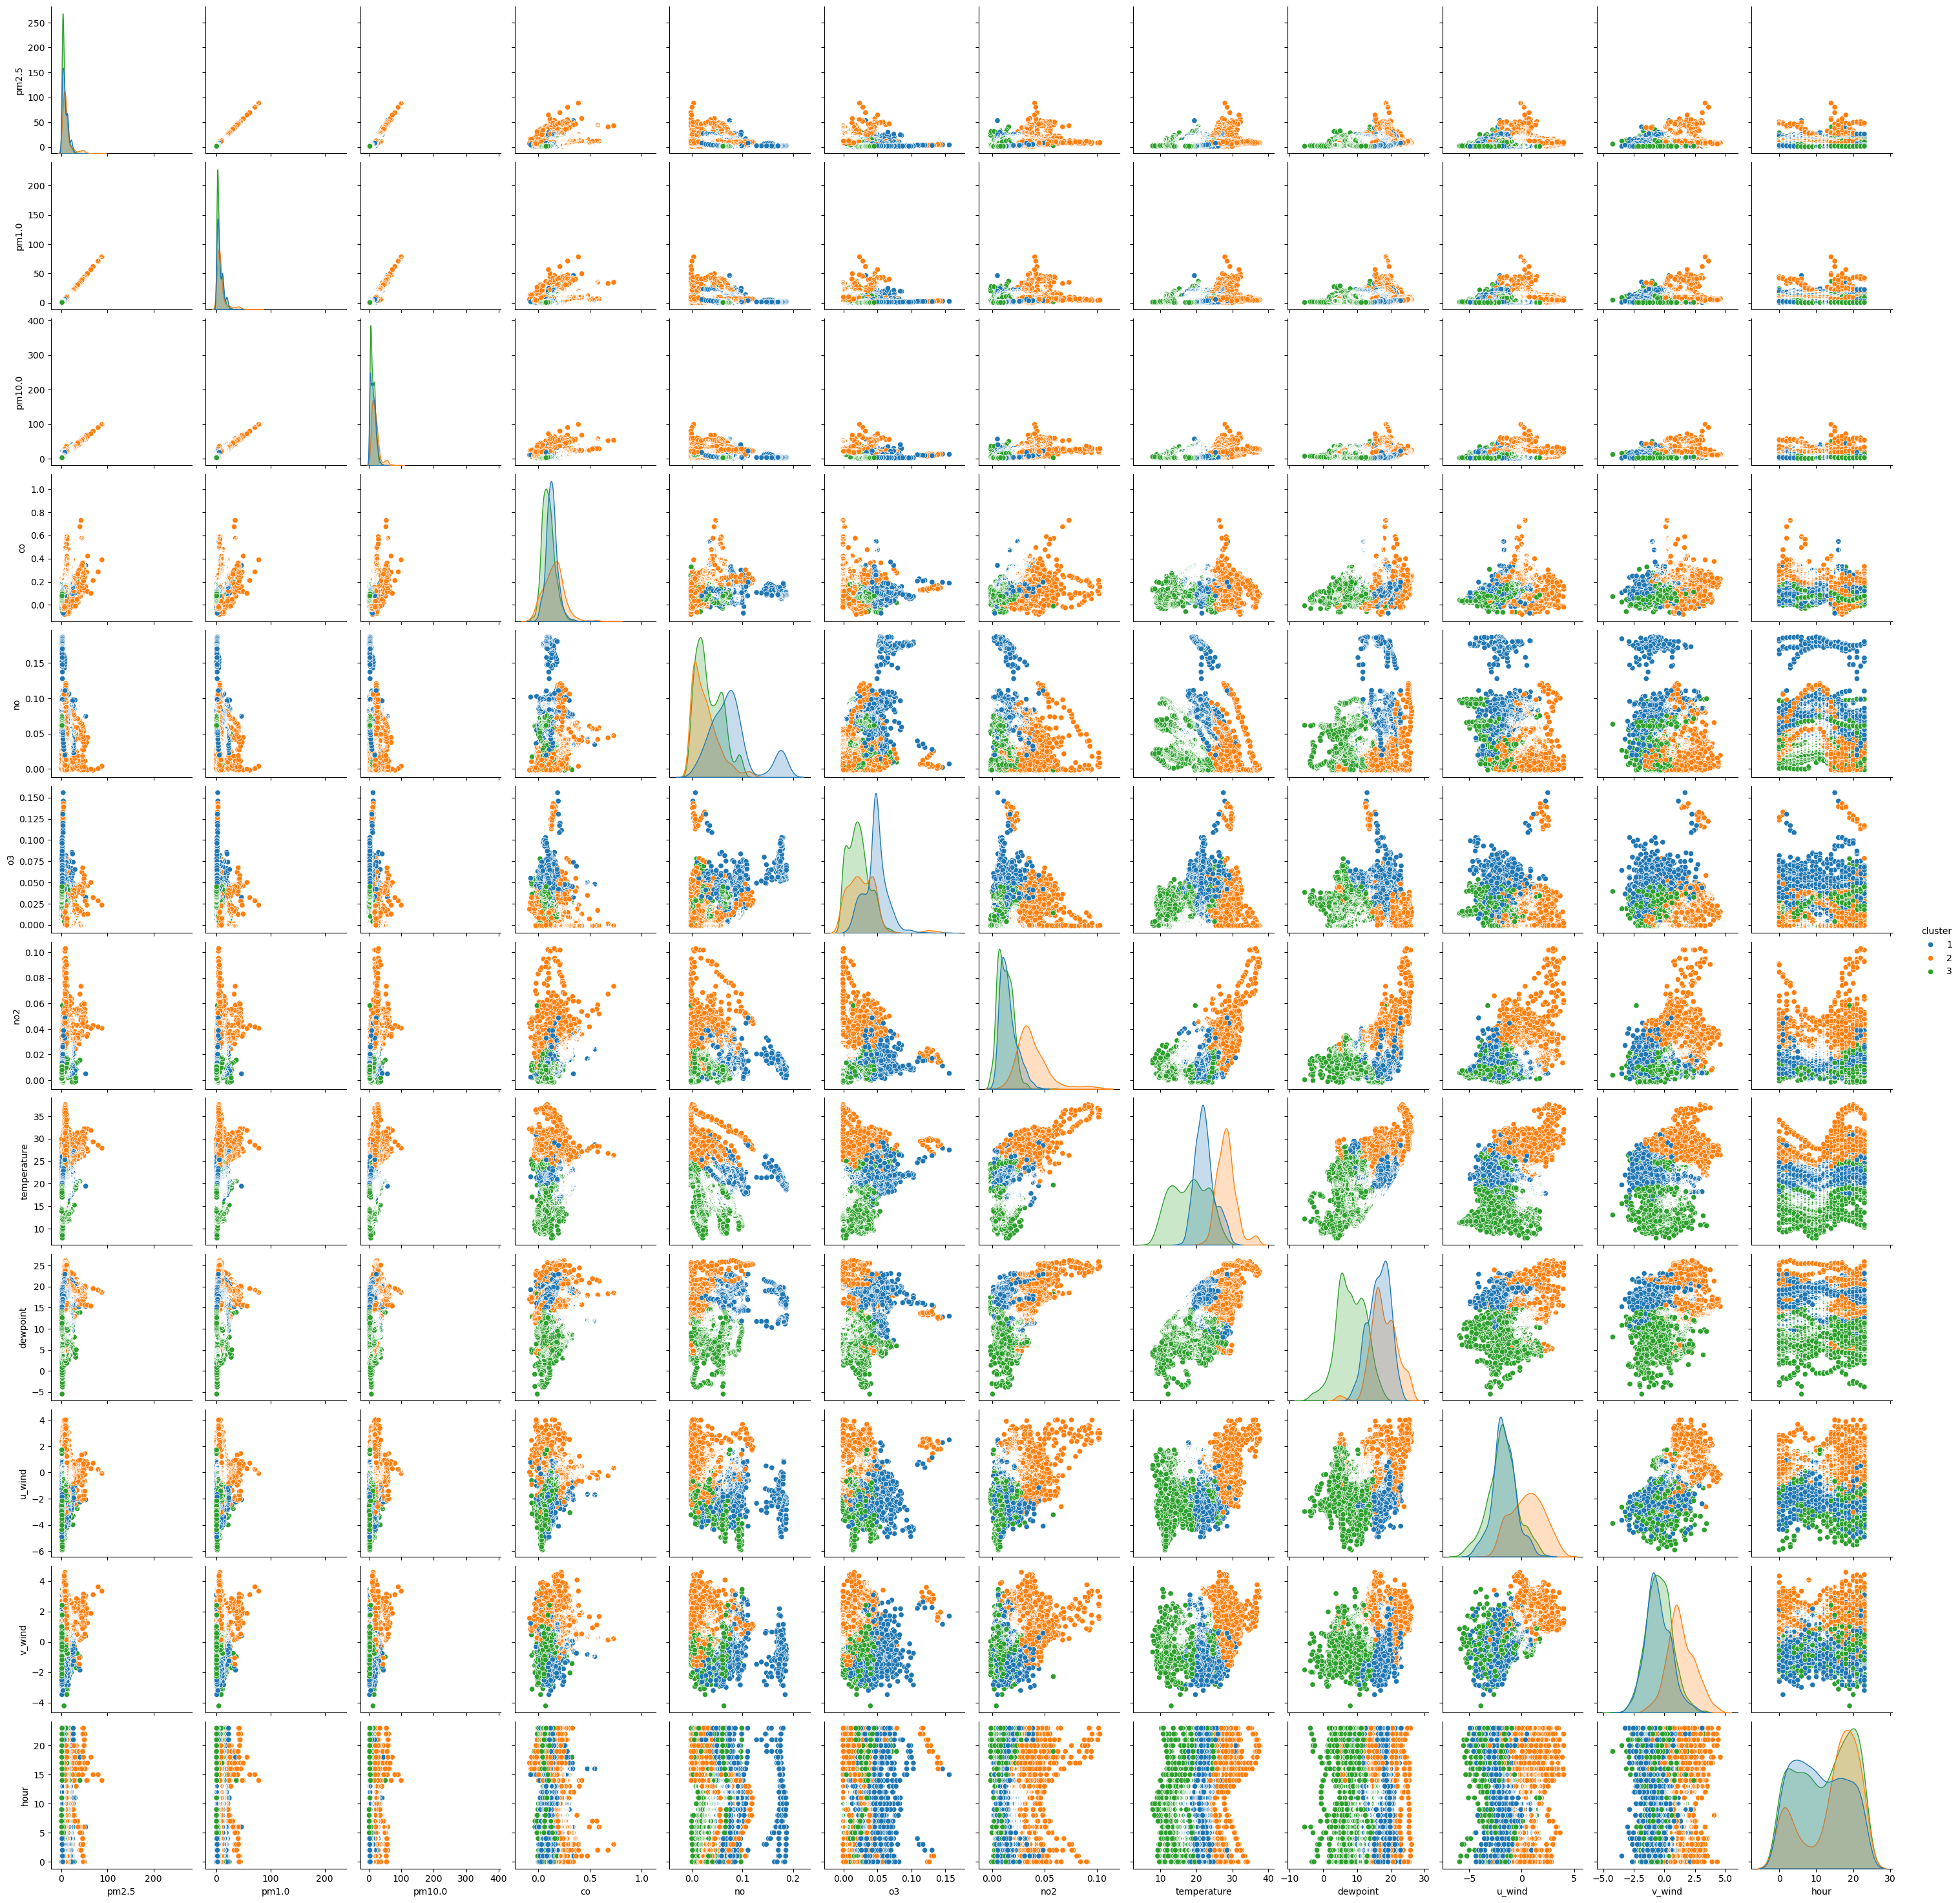

<Figure size 800x600 with 0 Axes>

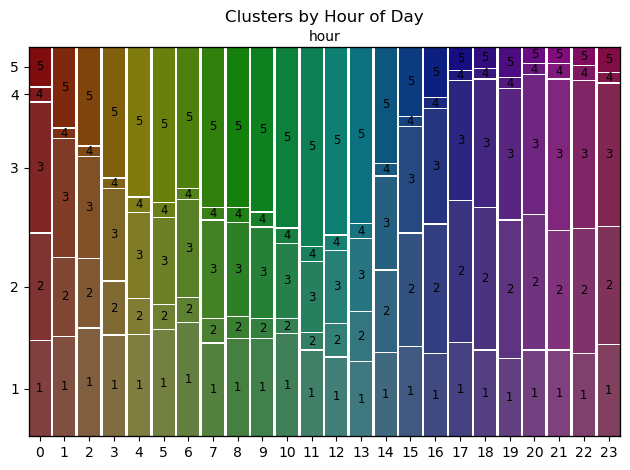

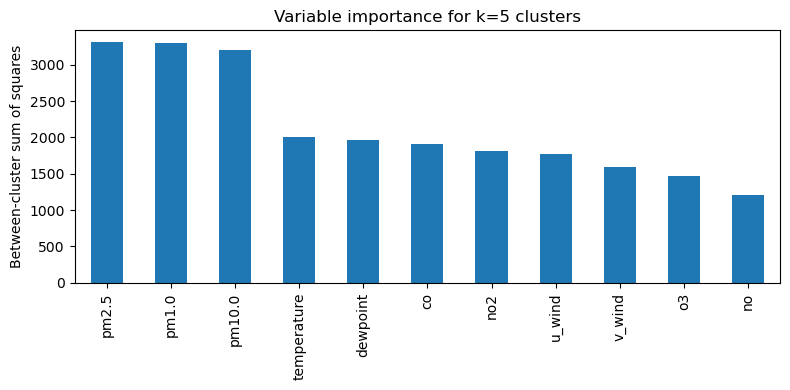

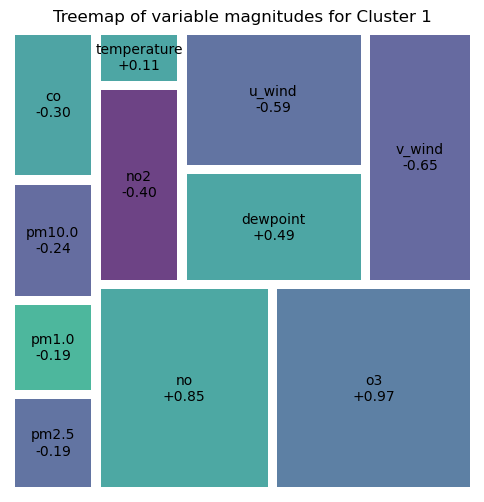

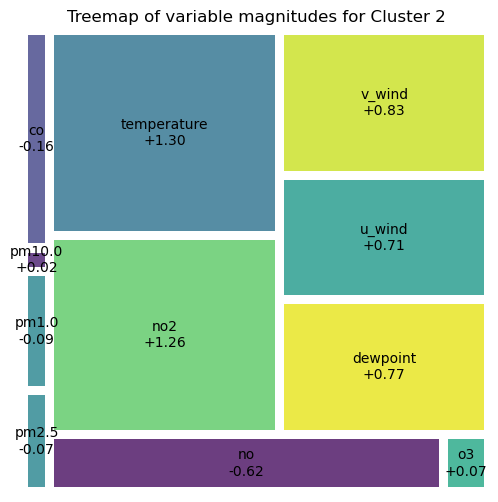

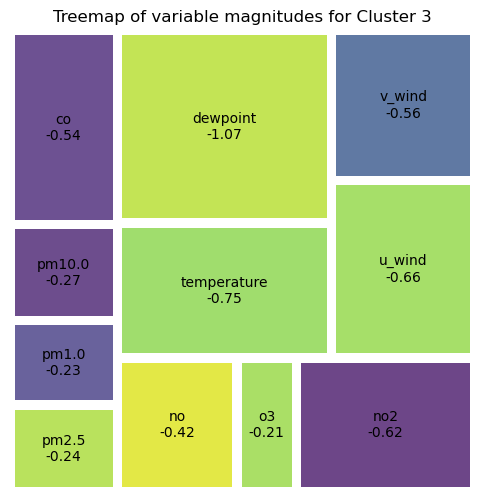

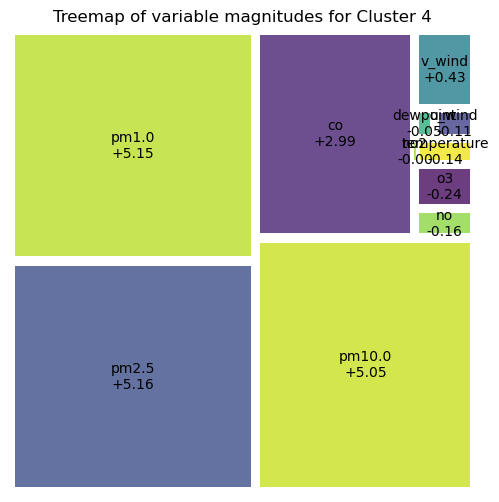

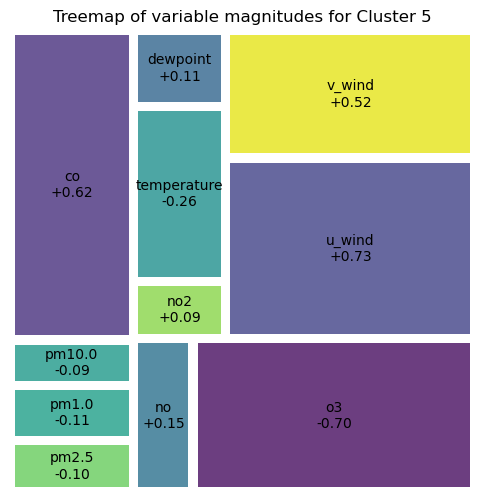

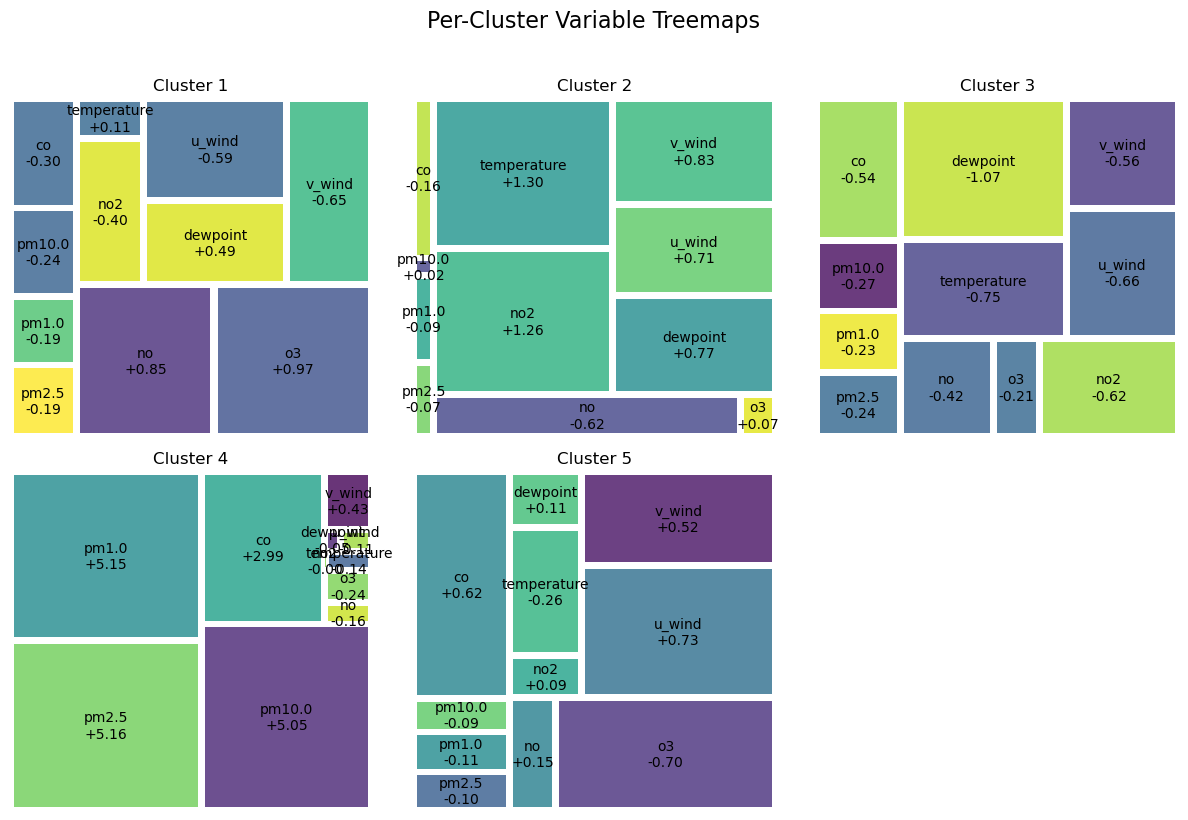

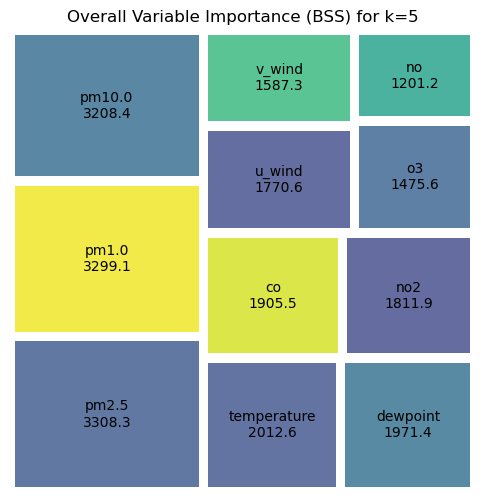

Wrote 120 timestamps for cluster 4 to 'cluster4_dates.txt'


In [3]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster      import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import squarify 
import math

# Number of clusters number
n = 5

# testing cluster id for text document output
nid = 4

def load_and_clean_with_time(ds_path, variables, time_dim='time'):
    ds = xr.open_dataset(ds_path, engine='netcdf4')
    arrays = [ds[v].to_numpy().ravel() for v in variables]
    times  = ds[time_dim].to_numpy().ravel()
    mask   = np.all([~np.isnan(a) for a in arrays], axis=0)
    data   = np.column_stack([a[mask] for a in arrays])
    times  = times[mask]
    df = pd.DataFrame(data, columns=variables)
    df['time'] = pd.to_datetime(times)
    return df

def cluster_and_attach(df, variables, n_clusters=n):
    # 1) Isolate just the numeric feature matrix
    X = df[variables].values
    
    # 2) standardize
    scaler = StandardScaler()
    X_norm = scaler.fit_transform(X)
    
    # 3) run k-means
    km = KMeans(n_clusters=n_clusters, random_state=42)
    labels0 = km.fit_predict(X_norm)
    
    # 4) attach labels (shifted to 1–5) back onto the original df
    df['cluster'] = labels0 + 1
    return df

def plot_cluster_histogram(df):
    counts = df['cluster'].value_counts().sort_index()
    plt.figure()
    plt.bar(counts.index, counts.values)
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of samples')
    plt.title('Cluster size distribution')
    plt.xticks(range(1, (n-1)))
    plt.tight_layout()
    plt.show()

def plot_all_variable_histograms(df):
    for var in df.columns:
        if var == 'cluster':
            continue
        plt.figure()
        df[var].hist(bins=50, edgecolor='black')
        plt.title(f'Histogram of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

def plot_variable_pairs(df):
    sns.pairplot(df, hue='cluster', hue_order=range(1, (n-1)), palette='tab10', corner=False)
    plt.show()

def plot_box_time(df, vars_list):
    df['hour'] = df.index.hour
    
    clusters = sorted(df['cluster'].unique())

    for var in vars_list:
        if var == 'cluster':
            continue   
        data = [df.loc[df['cluster'] == c, var].values for c in clusters]

        plt.figure()
        plt.boxplot(data, tick_labels=clusters, showfliers=False)
        plt.xlabel('Cluster ID')
        plt.ylabel(var.capitalize())
        plt.title(f'Boxplot of {var.capitalize()} by Cluster')
        plt.tight_layout()
        plt.show()

def mosaic_plot(df, cat1, cat2, title=None):
    """
    Draw a mosaic plot of the contingency table between cat1 and cat2.
    df: DataFrame containing both columns
    cat1, cat2: names of categorical columns in df
    """
    # build a contingency Series: a MultiIndex Series where
    # index is (cat1_value, cat2_value) → count
    ct = df.groupby([cat1, cat2]).size()
    
    # mosaic wants a dict mapping (val1, val2) pairs to counts
    data = ct.to_dict()
    
    plt.figure(figsize=(8,6))
    mosaic(data, title=title or f"Mosaic of {cat1} vs {cat2}", labelizer=lambda k: f"{k[1]}")  # show only the second category on tiles
    plt.xlabel(cat1)
    plt.ylabel(cat2)
    plt.tight_layout()
    plt.show()

def variable_importance_bss(df, variables, n_clusters=n, random_state=42):
    """
    Compute between-cluster sum of squares per variable on standardized data.
    Returns a pandas Series indexed by variable name, sorted descending.
    """
    # 1) Standardize
    X = df[variables].values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    
    # 2) Fit KMeans
    km = KMeans(n_clusters=n_clusters, random_state=random_state).fit(Xs)
    centers = km.cluster_centers_          # shape (K, p)
    labels  = km.labels_
    counts  = np.bincount(labels, minlength=n_clusters)  # length K
    
    # 3) Compute BSS_j = sum_k n_k * c_{k,j}^2
    #    centers**2 has shape (K,p); multiply each row by counts[:,None], then sum over k
    bss = np.sum(centers**2 * counts[:, None], axis=0)
    
    return pd.Series(bss, index=variables).sort_values(ascending=False)

def plot_cluster_treemap(km, variables, cluster_id):
    """
    df.cluster_centers_ is shape (K, p) in standardized units.
    cluster_id is 1-based (1…K).
    """
    center = km.cluster_centers_[cluster_id-1]        # zero‐based index
    sizes  = np.abs(center)                           # absolute z‐scores
    labels = [f"{v}\n{center[i]:+.2f}" for i,v in enumerate(variables)]
    
    # normalize sizes to sum to 100, to make plotting nicer
    total = sizes.sum()
    sizes_perc = sizes / total * 100

    plt.figure(figsize=(6,6))
    squarify.plot(
        sizes=sizes_perc,
        label=labels,
        alpha=0.8,
        pad=True
    )
    plt.title(f"Treemap of variable magnitudes for Cluster {cluster_id}")
    plt.axis('off')
    plt.show()

def plot_all_cluster_treemaps(km, variables, n_clusters=n, cols=3):
    """
    Draws a grid of treemaps, one per cluster, using km.cluster_centers_.
    
    km          : a fitted sklearn KMeans instance
    variables   : list of variable names (in the order you trained on)
    n_clusters  : number of clusters (5 in your case)
    cols        : how many columns in the grid
    """
    # layout
    rows = math.ceil(n_clusters / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = axes.flatten()
    
    for cid in range(1, n_clusters+1):
        ax = axes[cid-1]
        
        # get the standardized center for this cluster
        center = km.cluster_centers_[cid-1]
        sizes  = np.abs(center)
        labels = [f"{v}\n{center[i]:+.2f}" for i, v in enumerate(variables)]
        
        # normalize to 100%
        sizes = sizes / sizes.sum() * 100
        
        squarify.plot(
            sizes=sizes,
            label=labels,
            ax=ax,
            alpha=0.8,
            pad=True
        )
        ax.set_title(f"Cluster {cid}")
        ax.axis('off')
    
    # any leftover subplots get turned off
    for ax in axes[n_clusters:]:
        ax.axis('off')
    
    fig.suptitle("Per-Cluster Variable Treemaps", fontsize=16, y=1.02)
    fig.tight_layout()
    plt.show()

def export_cluster_dates(df, cluster_id=nid, filename=f'cluster{nid}_dates.txt'):
    # Select index values for cluster 4
    dates = df.index[df['cluster'] == cluster_id]
    # Write one ISO-formatted string per line
    with open(filename, 'w') as f:
        for dt in dates:
            f.write(dt.strftime('%Y-%m-%d %H:%M:%S') + '\n')
    print(f"Wrote {len(dates)} timestamps for cluster {cluster_id} to {filename!r}")

def main():
    vars_list = ['pm2.5','pm1.0','pm10.0','co','no','o3','no2','temperature','dewpoint','u_wind','v_wind']
    df = load_and_clean_with_time('D://Data//crocus_neiu_a1_and_filtered_30min.nc', vars_list)
    
    # pass in the list of numeric columns ONLY
    df = cluster_and_attach(df, vars_list, n_clusters=n)
    
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    df['hour'] = df.index.hour

    X = df[vars_list].values
    scaler = StandardScaler()
    Xs     = scaler.fit_transform(X)

    n_clusters = n
    km = KMeans(n_clusters=n_clusters, random_state=42).fit(Xs)

    print(df.head(10))                      # to check first 10 rows
    print(df['cluster'].value_counts().sort_index())
    hourly = df.groupby(['hour','cluster']).size().unstack(fill_value=0)
    hourly.plot(title='Hourly cluster frequency')
    plt.show()

    # function calls
    plot_cluster_histogram(df)
    plot_all_variable_histograms(df)
    plot_box_time(df, vars_list)
    plot_variable_pairs(df)

    df['hour'] = df.index.hour
    mosaic_plot(df, 'hour', 'cluster', title="Clusters by Hour of Day")

    # assume df is your cleaned DataFrame with no NaNs, before setting time index
    imp = variable_importance_bss(df, vars_list, n_clusters=n)
    
    # Plot it
    plt.figure(figsize=(8,4))
    imp.plot(kind='bar')
    plt.ylabel('Between-cluster sum of squares')
    plt.title(f'Variable importance for k={n} clusters')
    plt.tight_layout()
    plt.show()

    for cid in range(1, (n+1)):
        plot_cluster_treemap(km, vars_list, cluster_id=cid)

    plot_all_cluster_treemaps(km, vars_list, n_clusters=n, cols=3) 

    sizes  = imp.values
    labels = [f"{v}\n{imp[v]:.1f}" for v in imp.index]
    # 3) draw the single treemap
    plt.figure(figsize=(6,6))
    squarify.plot(
        sizes=sizes,
        label=labels,
        alpha=0.8,
        pad=True)
    plt.title(f"Overall Variable Importance (BSS) for k={n}")
    plt.axis('off')
    plt.show()

    export_cluster_dates(df, cluster_id=nid, filename=f'cluster{nid}_dates.txt')
    
if __name__ == '__main__':
    main()
